In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 1. Create Synthetic ECG Data
time_space = np.linspace(0, 100, 1000)
# Create a synthetic ECG-like signal: a sine wave with some added noise
ecg_signal = np.sin(time_space) + np.random.normal(scale=0.1, size=1000)
df = pd.DataFrame({'ECG': ecg_signal})
print(df['ECG'])

0      0.037149
1      0.128966
2      0.203101
3      0.293843
4      0.519883
         ...   
995   -0.925106
996   -0.672391
997   -0.707396
998   -0.701055
999   -0.478189
Name: ECG, Length: 1000, dtype: float64


In [3]:
sequence_length=20
def create_sequence(data,sequence_length):
    sequences=[]
    targets=[]
    for i in range(len(data)-sequence_length):
        sequence=data[i:i+sequence_length]
        target=data[i+sequence_length]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)
sequences,targets=create_sequence(df['ECG'].values,sequence_length)
# print(sequences.shape,sequences)
# print(targets.shape,targets)

In [4]:
X=torch.tensor(sequences,dtype=torch.float32).unsqueeze(-1)
y=torch.tensor(targets,dtype=torch.float32).unsqueeze(-1)
# print(X.shape,X)
# print(y.shape,y)


In [5]:
class ECG_RNN(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,num_layers=2):
        super(ECG_RNN,self).__init__()
        self.rnn=nn.RNN(input_size,hidden_size,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_size,1)
    def forward(self,x):
        rnn_output,_=self.rnn(x)
        # print("rnn_output ",rnn_output.shape,rnn_output)
        # print("_ hidden output",_.shape,_)
        output=self.fc(rnn_output[:,-1,:])
        # print("rnn_ouput[:,-1,:]",rnn_output[:,-1,:].shape,rnn_output[:,-1,:])
        # print(output)
        return output

In [6]:
model=ECG_RNN()
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.01)


In [12]:
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    predictions=model(X)
    loss=criterion(predictions,y)
    loss.backward()
    optimizer.step()
    if epoch%100==0:
        print(f"epoch ,loss:{loss}")

epoch ,loss:0.012878242880105972
epoch ,loss:0.012828618288040161
epoch ,loss:0.012779703363776207
epoch ,loss:0.012731458060443401
epoch ,loss:0.012683851644396782
epoch ,loss:0.012636866420507431
epoch ,loss:0.012590473517775536
epoch ,loss:0.012544660829007626
epoch ,loss:0.012499412521719933
epoch ,loss:0.012454714626073837


In [27]:
model.eval()
with torch.no_grad():
    test_seq = X[-1].unsqueeze(0)
    predictions = []
    forecast_steps = 50
    for i in range(forecast_steps):
        pred = model(test_seq)
        predictions.append(pred.item())
        print(f"Step {i + 1}, Predicted Value: {pred.item()}")
        pred = pred.unsqueeze(-1)
        test_seq = torch.cat((test_seq[:, 1:, :], pred), dim=1)


Step 1, Predicted Value: -0.5804311037063599
Step 2, Predicted Value: -0.5248546600341797
Step 3, Predicted Value: -0.4629458487033844
Step 4, Predicted Value: -0.39628008008003235
Step 5, Predicted Value: -0.3256712257862091
Step 6, Predicted Value: -0.25187382102012634
Step 7, Predicted Value: -0.17536458373069763
Step 8, Predicted Value: -0.09622858464717865
Step 9, Predicted Value: -0.0141710564494133
Step 10, Predicted Value: 0.07025076448917389
Step 11, Predicted Value: 0.15673363208770752
Step 12, Predicted Value: 0.2450380027294159
Step 13, Predicted Value: 0.333905428647995
Step 14, Predicted Value: 0.4218667447566986
Step 15, Predicted Value: 0.5082546472549438
Step 16, Predicted Value: 0.5903661251068115
Step 17, Predicted Value: 0.6672778129577637
Step 18, Predicted Value: 0.7357325553894043
Step 19, Predicted Value: 0.7953921556472778
Step 20, Predicted Value: 0.8441799879074097
Step 21, Predicted Value: 0.8813719749450684
Step 22, Predicted Value: 0.9069108963012695
Step 

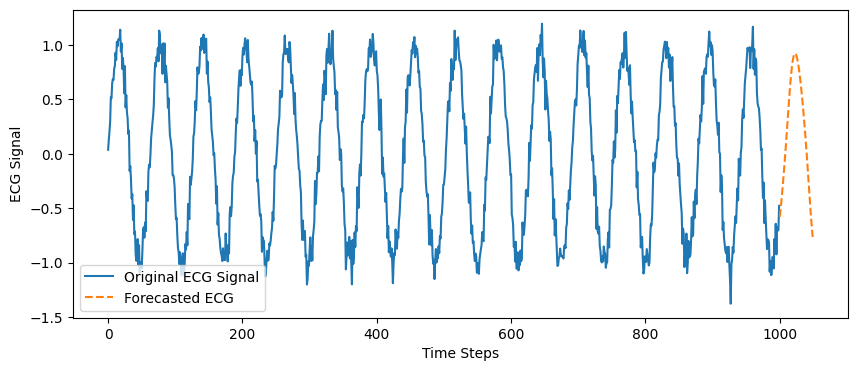

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(range(len(ecg_signal)), ecg_signal, label='Original ECG Signal')
plt.plot(range(len(ecg_signal), len(ecg_signal) + forecast_steps), predictions, label='Forecasted ECG', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('ECG Signal')
plt.legend()
plt.show()